#### 1. Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

<div class="alert alert-block alert-success">
<p>
По сути в исходном ноутбуке всё правильно. Обратил внимание на пару моментов: <br>
  
1) Классов всё таки 13. Отсутствующий класс 4 - это пешеход, который просто достаточно редко встречается, но он есть (отображен на первых фото)
<br>
2) В кастомном датасете в исходном ноутбуке был label_arr вместо self.label_arr, поэтому при обычном запуске вываливалась ошибка <br>
3) При обучении LOSS был отрицательный, но при этом он уменьшался в процессе обучения и результат на глаз получился нормальным. Причина в том, что outputs и labels получились не отмасштабированны. 


</p>
</div>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch.nn import functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [7]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [8]:
np.unique(plt.imread('D:/archive/dataA/dataA/CameraSeg/02_00_000.png')[:,:,0]*255)

array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

<div class="alert alert-block alert-success">
<p>
Классов у нас всё таки 13, просто класс 4 - пешеход, и он достаточно редкий   
</p>
</div>

In [9]:
mask = plt.imread('D:/archive/dataC/dataC/CameraSeg/F66-74.png')*255
#mask = np.where(mask == 1, 255, 0)

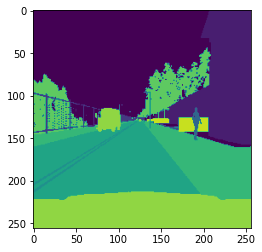

In [10]:
lab = np.asarray(plt.imread('D:/archive/dataC/dataC/CameraSeg/F66-74.png'))[:,:,0]*255
# lab[lab > 0.8] = 1
# lab[lab < 0.8] = 0
# lab = np.asarray(lab)*255

#lab = np.asarray(plt.imread(path + 'mask/mask00000001.png'))[:,:,0]*255
# Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
# но при этом заполняем 13 каналов масками нужных классов
# Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
# если не принадлежат классу, и 1 если принадлежат 
x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
for i in range(1, 13):
    mask1 = np.asarray(plt.imread('D:/archive/dataC/dataC/CameraSeg/F66-74.png'))[:,:,0]*255
    mask1 = np.where(mask1 == i, 255, 0)
    x = torch.as_tensor(mask1).unsqueeze(0)
    x_out =  torch.cat((x_out,x),dim=0)       
x_out = x_out.float()

lab = x_out.unsqueeze(0)
# делаем ресайз картинки на 256х256
lab = F.interpolate(input=lab, size=256, mode='nearest')


plt.imshow(torch.argmax(lab.squeeze(), dim=0).detach().cpu().numpy())

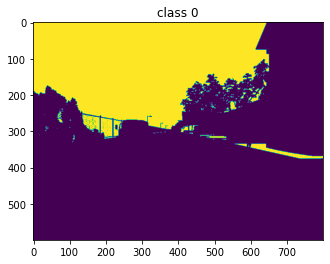

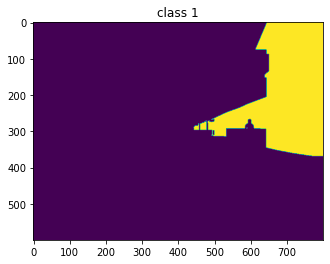

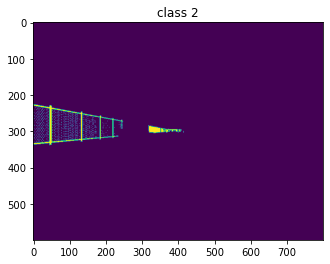

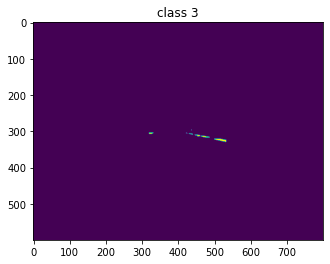

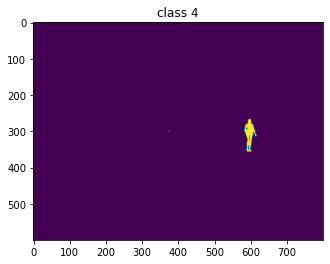

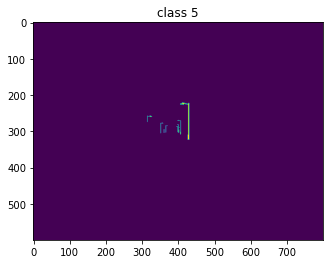

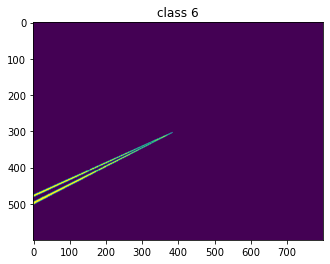

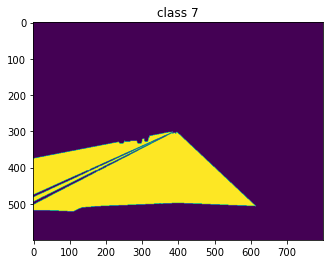

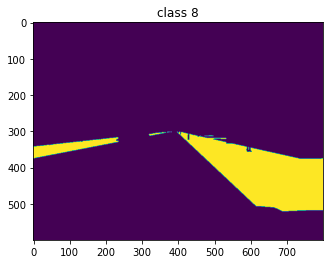

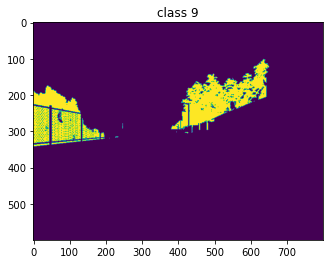

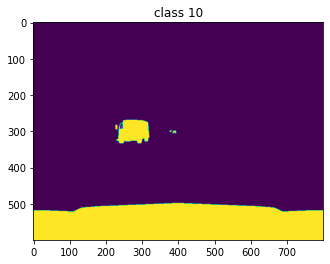

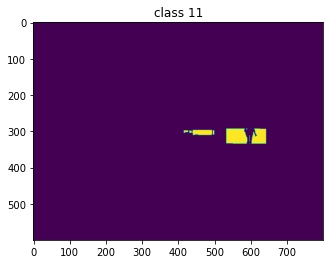

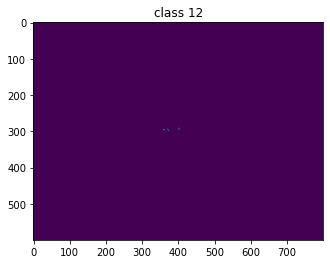

In [11]:
for i in range(13):
    mask = plt.imread('D:/archive/dataC/dataC/CameraSeg/F66-74.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [13]:
labels = ['Unlabeled','Building','Fence','Other',
                'Pedestrian', 'Pole', 'Roadline', 'Road',
                'Sidewalk', 'Vegetation', 'Car','Wall',
                 'Traffic sign']

In [14]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('D:/archive'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

In [15]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                        cameraRGB  \
0  D:/archive\dataA\dataA\CameraRGB\02_00_000.png   
1  D:/archive\dataA\dataA\CameraRGB\02_00_001.png   
2  D:/archive\dataA\dataA\CameraRGB\02_00_010.png   
3  D:/archive\dataA\dataA\CameraRGB\02_00_011.png   
4  D:/archive\dataA\dataA\CameraRGB\02_00_020.png   

                                        cameraSeg  
0  D:/archive\dataA\dataA\CameraSeg\02_00_000.png  
1  D:/archive\dataA\dataA\CameraSeg\02_00_001.png  
2  D:/archive\dataA\dataA\CameraSeg\02_00_010.png  
3  D:/archive\dataA\dataA\CameraSeg\02_00_011.png  
4  D:/archive\dataA\dataA\CameraSeg\02_00_020.png  


In [17]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [18]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

Затем разделим наш датасет на тренировочную и тестовую выборки.
И обернем их в наш кастомный класс.

In [19]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [20]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [21]:
learning_rate = 0.001
epochs = 3

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
Umodel = UNet(num_classes=13).to(device)

In [24]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [25]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [26]:
criterion = SoftDiceLoss()

In [27]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

3 epochs, 3500 total_steps per epoch


In [ ]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])
#         print(outputs.shape)
#         print(labels[0].size())
        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

In [28]:
savePATH = './selfLastModel.pth'
#torch.save(Umodel.state_dict(), savePATH)

In [29]:
net=UNet(13)
net.load_state_dict(torch.load(savePATH))

<All keys matched successfully>

In [30]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

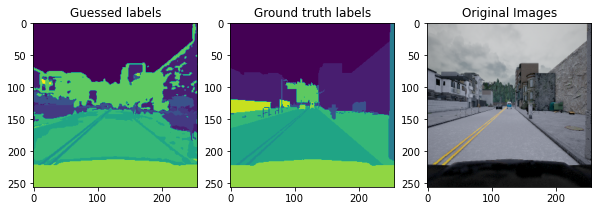

<ipython-input-31-4e159ffd1796>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

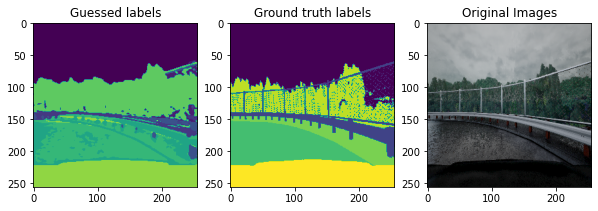

<Figure size 432x288 with 0 Axes>

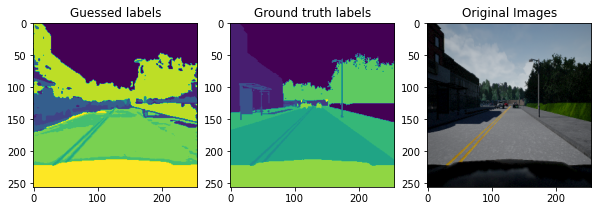

<Figure size 432x288 with 0 Axes>

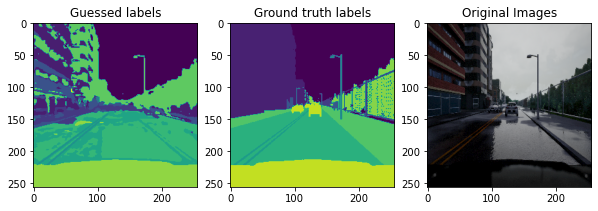

<Figure size 432x288 with 0 Axes>

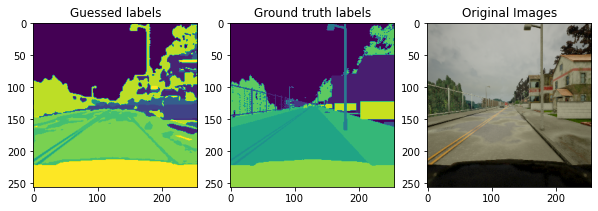

<Figure size 432x288 with 0 Axes>

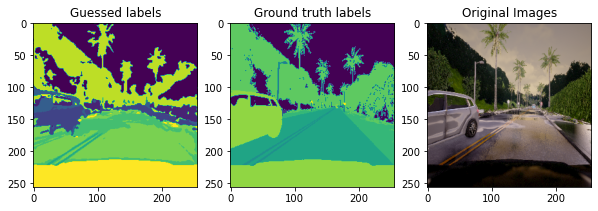

<Figure size 432x288 with 0 Axes>

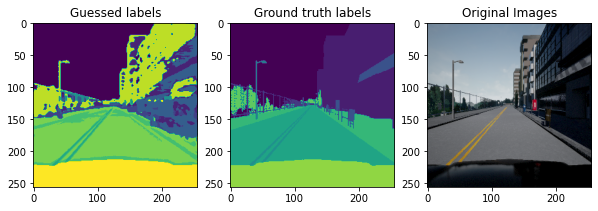

<Figure size 432x288 with 0 Axes>

In [31]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = net(images[0])
    f, axarr = plt.subplots(1,3, figsize=(10, 10))
    
    original = get_orig(images[0][0,:,:,:])
    
    axarr[0].imshow(torch.argmax(outputs[0].squeeze(), dim=0).detach().cpu().numpy())
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(torch.argmax(labels[0].squeeze(), dim=0).detach().cpu().numpy())
    axarr[1].set_title('Ground truth labels')
    
       
    axarr[2].imshow(original)
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

In [35]:
np.unique(labels)

array([  0., 255.], dtype=float32)